#**AI VIET NAM**
#**Transformer Applications**

#**Transformer**

In [1]:
import torchtext
import torch
import torch.nn as nn
from torch.nn import functional as F

d:\Asus\Ungdung\Miniconda\workspace\envs\AIOEx\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###**Transformer-Encoder**

####**Token and Positional Embedding**

In [2]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output

####**Transformer-Encoder Block**

In [3]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

####**Transformer-Encoder**

In [4]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, max_length, n_layers, embed_dim, num_heads, ff_dims, prob_drop, device='cpu'):
        super().__init__()

        self.token_pos_embedding = TokenAndPositionEmbedding(
            vocab_size, embed_dim, max_length, device)

        self.encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, ff_dims, prob_drop) for _ in range(n_layers)
        ])

    def forward(self, x):
        x = self.token_pos_embedding(x)
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x, x, x)
        return x

In [5]:
batch_size = 32
src_vocab_size = 1000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

In [6]:
input = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [7]:
# Test Encoder

test_x = TransformerEncoder(vocab_size=10_000, max_length=max_length, n_layers=8,
                            embed_dim=512, num_heads=8, ff_dims=2048, prob_drop=0.1)(input)
test_x.shape

torch.Size([32, 100, 512])

###**Transformer-Decoder**

####**Transformer Decoder Block**

In [8]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_3 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)
        self.dropout_3 = nn.Dropout(p=dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output, _ = self.attn(x, x, x, attn_mask=tgt_mask)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(x + attn_output)

        attn_output, _ = self.cross_attn(
            out_1, enc_output, enc_output, attn_mask=src_mask
        )
        attn_output = self.dropout_2(attn_output)
        out_2 = self.layernorm_2(out_1 + attn_output)

        ffn_output = self.ffn(out_2)
        ffn_output = self.dropout_2(ffn_output)
        out_3 = self.layernorm_2(out_2 + ffn_output)
        return out_3

####**Transformer-Decoder**

In [9]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, max_length, embed_dim, num_heads, ff_dims, prob_drop, n_layers, device='cpu'):
        super().__init__()

        self.token_pos_embedding = TokenAndPositionEmbedding(
            vocab_size, embed_dim, max_length, device)

        self.decoder_blocks = nn.ModuleList([
            TransformerDecoderBlock(embed_dim, num_heads, ff_dims, prob_drop) for _ in range(n_layers)
        ])

    def forward(self, x, enc_output, src_mask, tgt_mask):
        x = self.token_pos_embedding(x)
        for decoder_block in self.decoder_blocks:
            x = decoder_block(x, enc_output, tgt_mask, src_mask)
        return x

###**Transformer**

In [10]:
class Transformer(nn.Module):
    def __init__(self, scr_vocab_size, tgt_vocab_size, max_length, embed_dim, num_heads, ff_dims, prob_drop, n_layers, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = TransformerEncoder(
            scr_vocab_size, max_length, n_layers, embed_dim, num_heads, ff_dims, prob_drop, device)
        self.decoder = TransformerDecoder(
            tgt_vocab_size, max_length, embed_dim, num_heads, ff_dims, prob_drop, n_layers, device)

        self.linear = nn.Linear(embed_dim, tgt_vocab_size)

    def forward(self, src, tgt):
        encode_x = self.encoder(src)
        src_mask, tgt_mask = self.generate_mask(src, tgt)

        decode_x = self.decoder(tgt, encode_x, src_mask, tgt_mask)
        output = self.linear(decode_x)
        return output

    def generate_mask(self, src_sequence, tgt_squence):
        src_mask = torch.zeros(src_sequence.size(1), src_sequence.size(1)).to(
            self.device).type(torch.bool)
        tgt_mask = torch.triu(torch.ones(tgt_squence.size(1), tgt_squence.size(
            1)), diagonal=1).to(self.device)
        tgt_mask = tgt_mask.type(torch.float).masked_fill(
            tgt_mask == 1, float('-inf'))

        return src_mask, tgt_mask

In [11]:
batch_size = 128
src_vocab_size = 1000
tgt_vocab_size = 2000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dims = 256

In [12]:
model = Transformer(src_vocab_size, tgt_vocab_size, max_length, embed_dim, num_heads, ff_dims, 0.1, num_layers)

In [13]:
src = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [14]:
src

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 1,  ..., 1, 0, 1],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 1],
        [0, 0, 1,  ..., 1, 0, 1]])

In [15]:
tgt = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [16]:
prediction = model(src, tgt)

In [17]:
prediction.shape

torch.Size([128, 100, 2000])

#**Text Classification using Transformer-Encoder**

In [18]:
import os
import pandas as pd

###**Load Dataset**

In [19]:
def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
                sentence = " ".join(lines)
                if label == "neg":
                    label = 0
                if label == "pos":
                    label = 1
                data = {
                    'sentence': sentence,
                    'label': label
                }
                examples.append(data)
    return pd.DataFrame(examples)


folder_paths = {
    'train': './data/ntc-scv/data_train/train',
    'valid': './data/ntc-scv/data_train/test',
    'test': './data/ntc-scv/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

###**Preprocessing**

In [20]:
train_df.head()

,sentence,label
0,Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi h...,0
1,Thứ 6 nào ta cùng quẩy 💣 💣 💣\n Vuvuzela beer c...,0
2,"Mình đi với nhóm , tổng_cộng 4 người ăn chỉ có...",0
3,"nhân_viên phục_vụ không mấy tận_tình , đồ_ăn r...",0
4,"Vào đây thì hết bàn , nhưng mình vẫn ngồi đợi ...",0


**Text Cleaning**

In [21]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [22]:
train_df_vi = train_df.copy()
train_df_vi['preprocess_sentence'] = train_df_vi['sentence'].apply(
    preprocess_text)

valid_df_vi = valid_df.copy()
valid_df_vi['preprocess_sentence'] = valid_df_vi['sentence'].apply(
    preprocess_text)

test_df_vi = test_df.copy()
test_df_vi['preprocess_sentence'] = test_df_vi['sentence'].apply(
    preprocess_text)


###**Representation**

In [23]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [24]:
# word-based tokenizer
import torchtext
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [25]:
train_df_vi['preprocess_sentence'][0]

'mua có mỗi bingsu thập cẩm k mà mình f đợi hơn hỏi lại thì nv tl có r nhg bảo chờ thêm nữa tụi e lm liền mình k biết có ngon k nhg cũng muốn ăn thử thiết nghĩ nv quán nên xem lại cách pv và nc vs khách'

### Xây dựng vocabulary

In [26]:
train_df_vi

,sentence,label,preprocess_sentence
0,Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi h...,0,mua có mỗi bingsu thập cẩm k mà mình f đợi hơn...
1,Thứ 6 nào ta cùng quẩy 💣 💣 💣\n Vuvuzela beer c...,0,thứ nào ta cùng quẩy vuvuzela beer club chung ...
2,"Mình đi với nhóm , tổng_cộng 4 người ăn chỉ có...",0,mình đi với nhóm tổng cộng người ăn chỉ có khô...
3,"nhân_viên phục_vụ không mấy tận_tình , đồ_ăn r...",0,nhân viên phục vụ không mấy tận tình đồ ăn ra ...
4,"Vào đây thì hết bàn , nhưng mình vẫn ngồi đợi ...",0,vào đây thì hết bàn nhưng mình vẫn ngồi đợi bì...
...,...,...,...
29995,2-9 mình đi với nhóm bạn tổng_cộng là 8ng.Thiệ...,1,mình đi với nhóm bạn tổng cộng là ng thiệt hại...
29996,sushi bình_dân mà chất_lượng không bình_dân ch...,1,sushi bình dân mà chất lượng không bình dân ch...
29997,Trời_ơi từ bé đến lớn chưa thử món kem nào bằn...,1,trời ơi từ bé đến lớn chưa thử món kem nào bằn...
29998,Nge mn cũng ns ngon nên hni đến coi thế_nào .\...,1,nge mn cũng ns ngon nên hni đến coi thế nào qu...


In [27]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [28]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for i, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label


train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df_vi)
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(test_df_vi)
test_dataset = to_map_style_dataset(test_dataset)

In [29]:
for i, row in train_df_vi.iterrows():
    print(vocabulary(tokenizer(row['preprocess_sentence'])))
    break

[141, 4, 207, 893, 917, 861, 14, 16, 3, 2616, 242, 77, 188, 21, 8, 370, 2554, 4, 565, 1289, 216, 283, 98, 57, 421, 609, 2849, 662, 3, 14, 121, 4, 11, 14, 1289, 10, 176, 2, 99, 653, 332, 370, 7, 18, 288, 21, 191, 1388, 9, 691, 278, 61]


###**Dataloader**

In [30]:
import torch

seq_length = 100

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence+([0]* (seq_length-len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

In [31]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [32]:
next(iter(train_dataloader))

(tensor([[ 191,  622,  159,  ...,    0,    0,    0],
         [   6,  176,  885,  ..., 1112,    5,   76],
         [   7,  298,  205,  ...,  115,   43,   58],
         ...,
         [ 119,  227,   86,  ...,  117, 2596,  992],
         [ 142,   66,   63,  ...,  194,  219,  146],
         [ 303,  217,  225,  ..., 1088, 2227, 1350]]),
 tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
         0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
         0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
         0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
         0, 1, 1, 0, 1, 0, 1, 0]))

In [33]:
len(train_dataloader)

235

In [34]:
encoded_sentences, labels = next(iter(train_dataloader))

In [35]:
encoded_sentences.shape

torch.Size([128, 100])

In [36]:
labels.shape

torch.Size([128])

###**Trainer**

In [37]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [38]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [39]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt', weights_only=True))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [40]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

###**Modeling**
- Trước khi đưa vào conv phải theo format : (batch_size, Channels, Width, Height)

In [41]:
# target output size of 5
m = nn.AdaptiveAvgPool1d(1)
input = torch.randn(1, 5, 5)
output = m(input)
output.squeeze()

tensor([-0.0457, -0.4289, -0.1787, -0.3802,  0.0242])

In [42]:
# target output size of 5
m = nn.AvgPool1d(kernel_size=max_length)
input = torch.randn(1, 64, max_length)
output = m(input)
output.shape

torch.Size([1, 64, 1])

In [43]:
class TransformerEncoderCls(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, n_layers, num_heads, ff_dims, prob_drop, device='cpu'):
        super().__init__()

        self.token_pos_embedding = TokenAndPositionEmbedding(
            vocab_size, embed_dim, max_length, device)

        self.encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, ff_dims, prob_drop) for _ in range(n_layers)
        ])
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(embed_dim, 20)
        self.fc2 = nn.Linear(20, 2)
        self.dropout = nn.Dropout(p=prob_drop)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.token_pos_embedding(x)
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x, x, x)
            
        # squeeze vứt hết dim = 1
        x = self.avg_pool(x.permute(0, 2, 1)).squeeze()
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        x = self.fc2(x)

        return x
        

In [44]:
vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout=0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerEncoderCls(
    vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dims, dropout
)

In [45]:
encoded_sentences.shape

torch.Size([128, 100])

In [46]:
predictions = model(encoded_sentences)

In [47]:
predictions.shape

torch.Size([128, 2])

In [48]:
predictions.shape

torch.Size([128, 2])

###**Training**

In [49]:
import os
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerEncoderCls(
    vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dims, dropout
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


| epoch   1 |    50/  235 batches | accuracy    0.522
| epoch   1 |   100/  235 batches | accuracy    0.576
| epoch   1 |   150/  235 batches | accuracy    0.638
| epoch   1 |   200/  235 batches | accuracy    0.696
-----------------------------------------------------------
| End of epoch   1 | Time: 184.28s | Train Accuracy    0.721 | Train Loss    0.649 | Valid Accuracy    0.741 | Valid Loss    0.544 
-----------------------------------------------------------
| epoch   2 |    50/  235 batches | accuracy    0.738
| epoch   2 |   100/  235 batches | accuracy    0.772
| epoch   2 |   150/  235 batches | accuracy    0.784
| epoch   2 |   200/  235 batches | accuracy    0.785
-----------------------------------------------------------
| End of epoch   2 | Time: 192.31s | Train Accuracy    0.792 | Train Loss    0.485 | Valid Accuracy    0.793 | Valid Loss    0.449 
-----------------------------------------------------------
| epoch   3 |    50/  235 batches | accuracy    0.794
| epoch   

d:\Asus\Ungdung\Miniconda\workspace\envs\AIOEx\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()


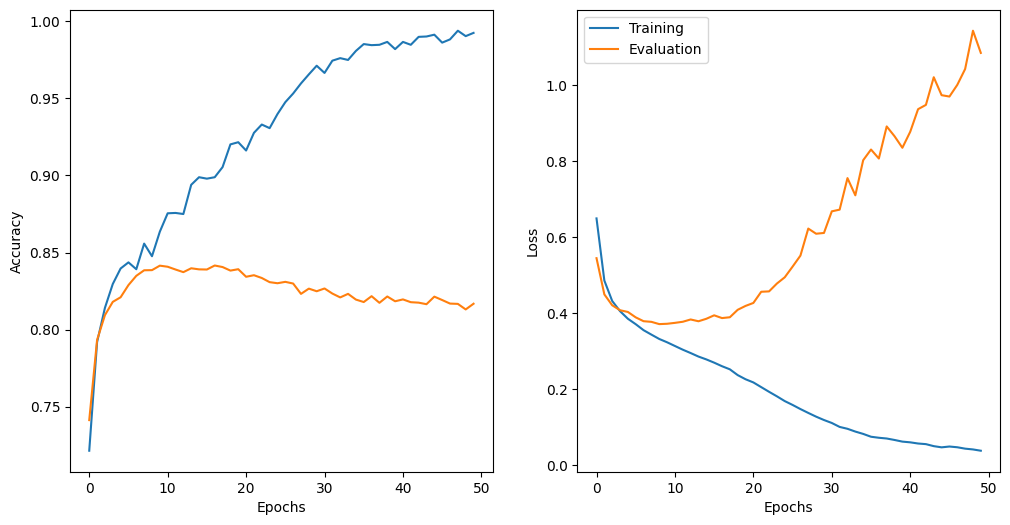

In [50]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [51]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.8223, 1.0224487068532389)